# Long Lasting effect of LPS-SI on myelopoiesis
Author: Farid Keramati  
Date: 03/10/2022

Use the following code to investigate the long lasting effects of LPS-induced systemic inflammation bone marrow-resident hematopoietic stem cells (HSCs) and myelopoiesis. This analysis uses data of all three time points:
* Day 0 (before LPS-SI)
* 4h (acute phase of systemic inflammation)
* Day 7 (late phase, demonstrating long lasting effects)

To run the following code, we will use the Seurat object generated in the [first analysis script](https://github.com/fkeramati/LPS-SI/blob/main/Analysis%20Scripts/All%20Bone%20Marrow%20Mononuclear%20Cell%20from%20All%20Time%20Points.ipynb).<br></br>
We will subset HSCs and myeloid cells to focus on the myelopoiesis.

### Load required packages

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))

### Read in previously generated Seurat object and subset HSC + myeloid cells

In [2]:
bm = readRDS("./Bonemarrow_allCells_allTimePoints_MNN_batchCorrected.rds")
myelo_tmp = subset(bm, idents = c("HSC", "GMP", "Monocyte", "Inflam Mono", "Non Cla Mono", "cDC"))

counts = GetAssayData(myelo_tmp, slot = "counts")
myelo = CreateSeuratObject(counts = counts, project = "myelo", min.cells = 0, min.features = 0)
rm(myelo_tmp, counts)

### Normalize, scale and perform dimentionality reduction
After each round of visualization, I will remove few contaminating cells (from other lineages), to get to a pure population of HSC + myeloid cells.

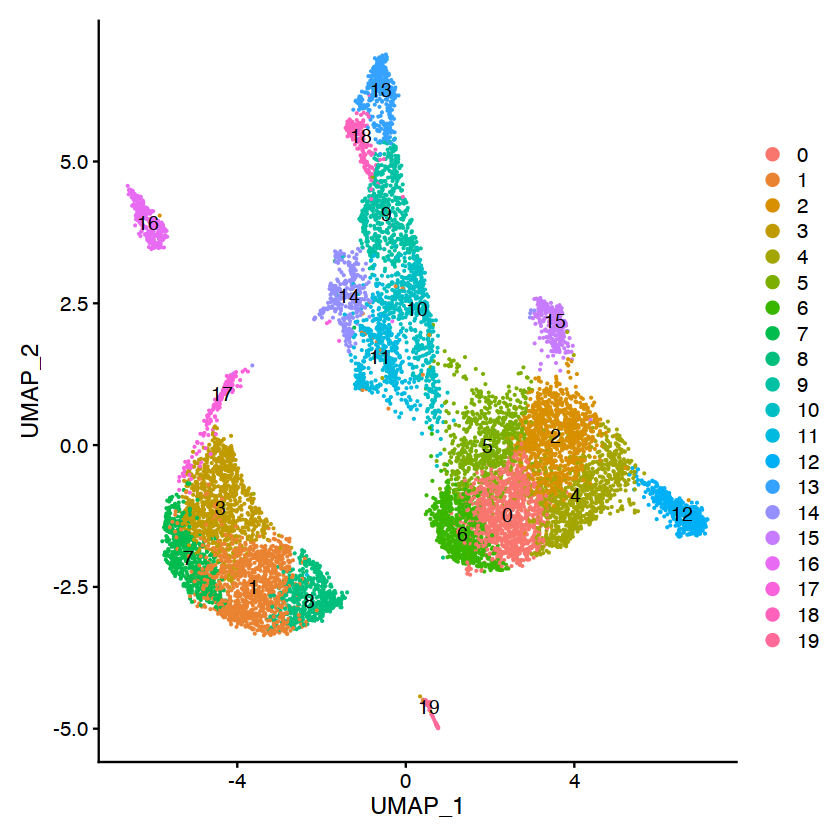

In [3]:
# Normalize and Scale
myelo = NormalizeData(myelo, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
s.genes = cc.genes.updated.2019$s.genes
g2m.genes = cc.genes.updated.2019$g2m.genes
myelo = CellCycleScoring(myelo, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)
myelo$CC.Difference = myelo$S.Score - myelo$G2M.Score
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)

# PCA, UMAP visualization and clustering
myelo = RunPCA(myelo, verbose = F)
myelo = suppressWarnings(RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:16, verbose = F))
myelo = FindNeighbors(myelo, dims = 1:16, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
myelo@meta.data$Donor = unlist(strsplit(names(myelo$orig.ident), split = "_"))[c(T,F,F)]
myelo@meta.data$TimePoint = unlist(strsplit(names(myelo$orig.ident), split = "_"))[c(F,T,F)]
DimPlot(myelo, label = T, pt.size = 0.1)

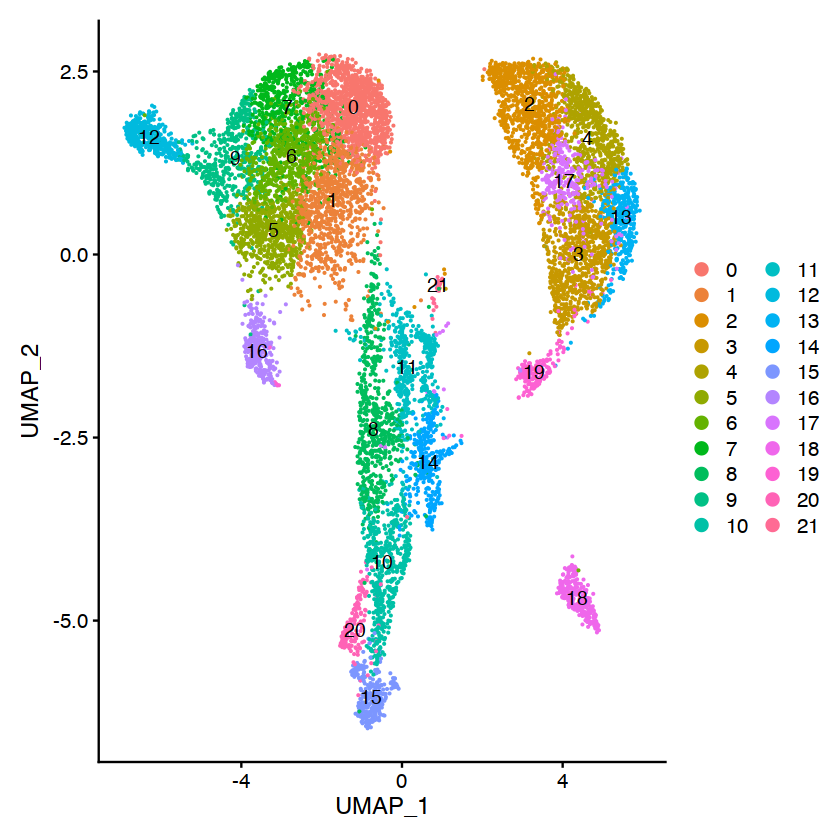

In [4]:
# Remove cluster 19 (contaminating stromal cells in the myeloid lineage)
myelo = subset(myelo, idents = 19, invert = T)

# Run normalization and clustering again
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)
myelo = RunPCA(myelo, verbose = F)
myelo = RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:17, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:17, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
DimPlot(myelo, label = T, pt.size = 0.1)

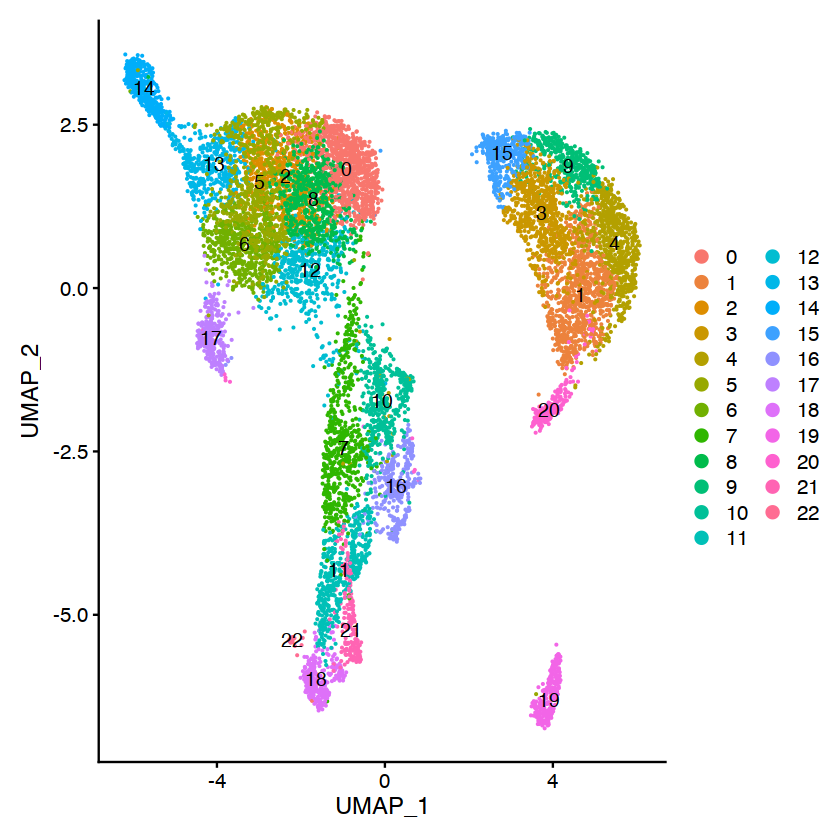

In [5]:
# Remove cluster 21 (contaminating Erythrocytes in the myeloid lineage)
myelo = subset(myelo, idents = 21, invert = T)

# Run normalization and clustering again
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)
myelo = RunPCA(myelo, verbose = F)
myelo = RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:17, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:17, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
DimPlot(myelo, label = T, pt.size = 0.1)

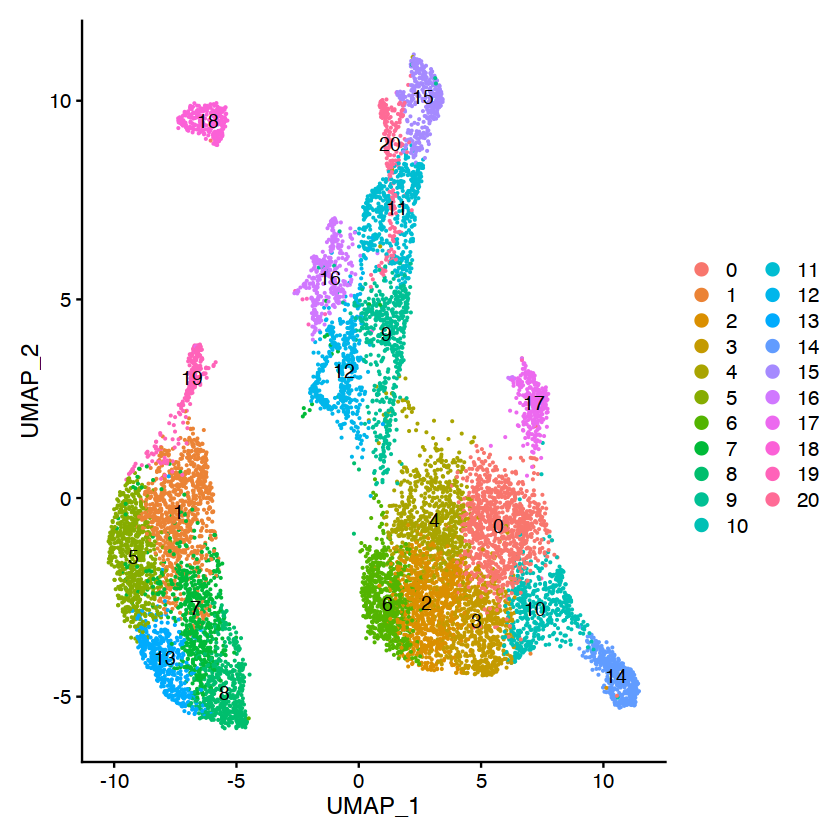

In [6]:
# Remove cluster 22 (contaminating T cells in the myeloid lineage)
myelo = subset(myelo, idents = 22, invert = T)

# Run normalization and clustering again
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)
myelo = RunPCA(myelo, verbose = F)
myelo = RunUMAP(myelo, dims = 1:17, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:15, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
DimPlot(myelo, label = T, pt.size = 0.1)

### Batch correct using MNN and visualize cells

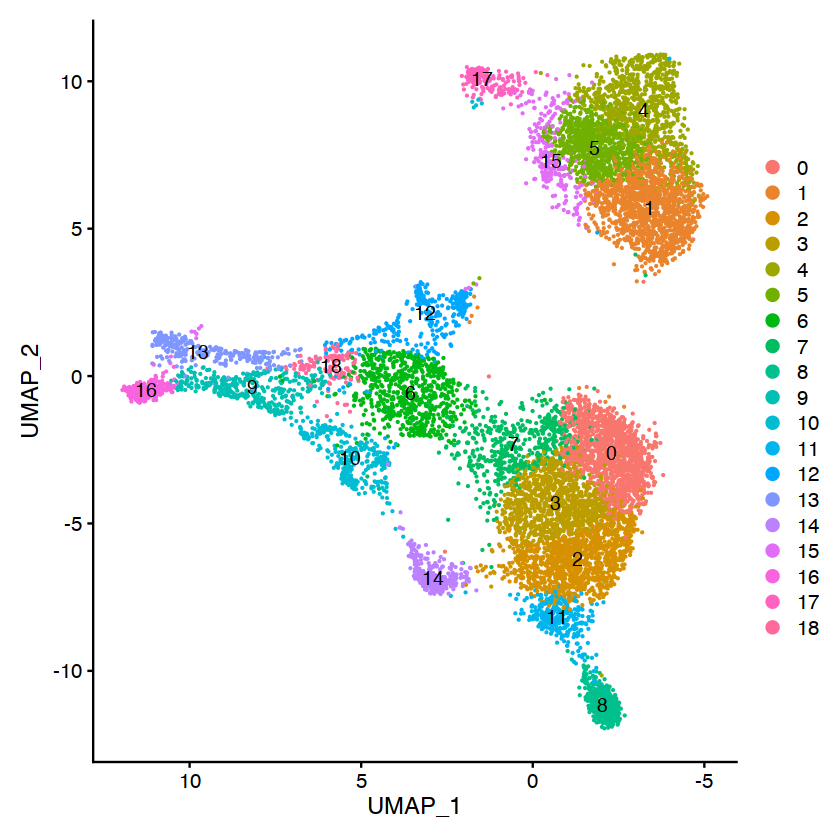

In [7]:
# There is a donor batch effect, correct for it using MNN
myelo_mnn = RunFastMNN(object.list = SplitObject(myelo, split.by = "Donor"), features = 3000, verbose = F)
myelo_mnn = RunUMAP(myelo_mnn, dims = 1:30, reduction = "mnn", min.dist = 0.35, verbose = F)
myelo_mnn = FindNeighbors(myelo_mnn, dims = 1:30, reduction = "mnn", k.param = 20, verbose = F)
myelo_mnn = FindClusters(myelo_mnn, resolution = 1.5, verbose = F)
DimPlot(myelo_mnn, label = T) + scale_x_reverse()

### Refine cell clustering and assign cell types to each cluster

In [8]:
# Further sub-cluster cluster 0 
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 0, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.3, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 12 
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 12, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.2, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 13
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 13, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.2, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 3
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 3, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.5, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 3_0
myelo_mnn = FindSubCluster(myelo_mnn, cluster = "3_0", graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.5, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 6
myelo_mnn = FindSubCluster(myelo_mnn, cluster = "6", graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.2, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1385
Number of edges: 40134

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7188
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 315
Number of edges: 8712

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8639
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 289
Number of edges: 10053

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8567
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1126
Number of edges: 35542

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6276
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer versio

In [9]:
# Name Clusters
myelo_mnn = RenameIdents(myelo_mnn, "0_0" = "Pro Mono", 
                         "0_1" = "Monocyte", 
                         "1" = "Inflam Pro Mono", 
                         "2" = "Monocyte", 
                         "3_0_0" = "Monocyte", 
                         "3_0_1" = "Pro Mono", 
                         "3_1" = "Monocyte", 
                         "3_2" = "Pro Mono", 
                         "4" = "Inflam Mono", 
                         "5" = "Inflam Pro Mono", 
                         "6_0" = "Cycling Pro Mono", 
                         "6_1" = "GMP", 
                         "7" = "Pro Mono", 
                         "8" = "Non Cla Mono", 
                         "9" = "ST-HSC", 
                         "10" = "Prog cDC", 
                         "11" = "Inter Mono", 
                         "12_0" = "Inflam GMP", 
                         "12_1" = "Cycling Inflam Pro Mono", 
                         "12_2" = "Cycling Inflam Pro Mono", 
                         "13_0" = "Inflam LT-HSC", 
                         "13_1" = "Inflam ST-HSC", 
                         "14" = "cDC", 
                         "15" = "Inflam Pro Mono", 
                         "16" = "LT-HSC", 
                         "17" = "Inflam cDC", 
                         "18" = "GMP")
myelo_mnn$CellType = myelo_mnn@active.ident
myelo_mnn$CellType = factor(myelo_mnn$CellType, levels = c("LT-HSC", "ST-HSC", "Inflam LT-HSC", "Inflam ST-HSC", "GMP", "Inflam GMP", 
                                                           "Cycling Pro Mono", "Cycling Inflam Pro Mono", "Prog cDC", "Pro Mono", "Monocyte", "Inter Mono", 
                                                           "Non Cla Mono", "Inflam Pro Mono", "Inflam Mono", "cDC", "Inflam cDC"))

### Visualize cells (colored by cell type)

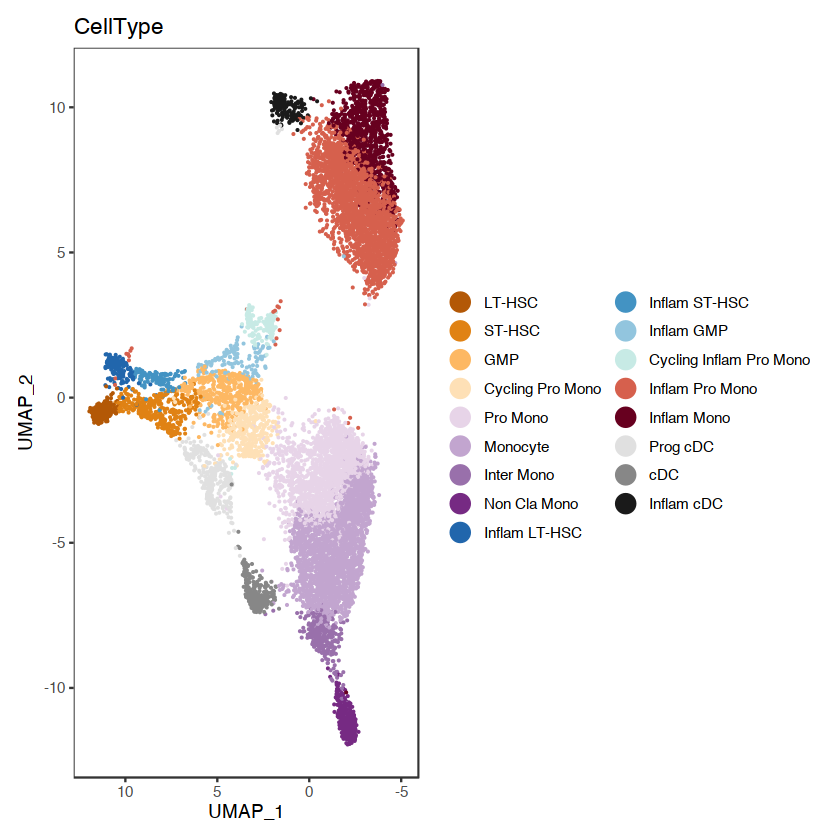

In [10]:
DimPlot(myelo_mnn, pt.size=0.1, group.by="CellType") + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
  scale_color_manual(values=c("LT-HSC"="#b35806",
                              "ST-HSC"="#e08214",
                              "GMP"="#fdb863",
                              "Cycling Pro Mono"="#fee0b6",
                              "Pro Mono"="#e7d4e8",
                              "Monocyte"="#c2a5cf",
                              "Inter Mono"="#9970ab",
                              "Non Cla Mono"="#762a83",
                              "Inflam LT-HSC"="#2166ac", 
                              "Inflam ST-HSC"="#4393c3",
                              "Inflam GMP"="#92c5de", 
                              "Cycling Inflam Pro Mono"="#c7eae5", 
                              "Inflam Pro Mono"="#d6604d", 
                              "Inflam Mono"="#67001f", 
                              "Prog cDC"="#e0e0e0", 
                              "cDC"="#878787",
                              "Inflam cDC"="#1a1a1a")) +
  guides(color=guide_legend(ncol=2, override.aes = list(size=5))) + scale_x_reverse()

### Visualize cells (colored by time point)

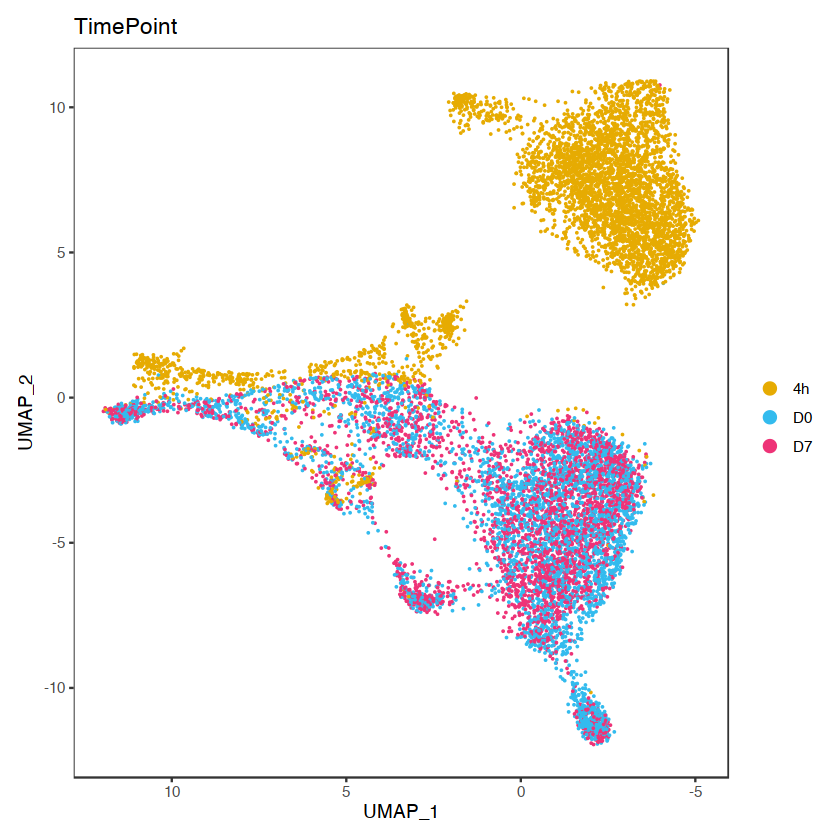

In [11]:
DimPlot(myelo_mnn, label = F, pt.size = 0.01, group.by = "TimePoint", shuffle = T) + scale_color_manual(values=c("#e6ab02", "#33bbee", "#ee3377")) +
  theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + scale_x_reverse()

### Save object

In [12]:
saveRDS(myelo_mnn, "Myeloid_All_timePoints_longLastingEffect_MNN_batchCorrected.rds")